# Deep Hedging of Green PPAs

In [1]:
from sys import exit

In [1]:
import datetime as dt
import sys
sys.path.insert(0,'../..')
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import numpy as np
from scipy.special import comb
import pandas as pd
import seaborn
import pprint
import deepdiff
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"




In [2]:
from rivapy.tools.datetime_grid import DateTimeGrid
from rivapy.models.residual_demand_fwd_model import WindPowerForecastModel, MultiRegionWindForecastModel, LinearDemandForwardModel
from rivapy.instruments.ppa_specification import GreenPPASpecification
from rivapy.models.residual_demand_model import SmoothstepSupplyCurve
from rivapy.models import OrnsteinUhlenbeck
from rivapy.pricing.green_ppa_pricing import GreenPPADeepHedgingPricer, DeepHedgeModel


import analysis

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%load_ext autoreload
%autoreload 2
%matplotlib inline

c:\Users\Anwender\Documents\GitHub\RiVaPy_development\RiVaPy\sandbox\green_ppa\../..\rivapy\__init__.py:11: UserWarning: The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.
  warnings.warn('The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.')


In [3]:
def setup(ref_key, ref_key_volume_hedge):
    sim_results = {}
    forecast_points={}
    # simulate paths
    print('simulate paths')
    for k in ref_keys:
        sim_results[k], forecast_points[k] = repo.simulate_model(k, n_sims=100_000)
    # load models and specs
    print('load models and specs')
    hedge_models = {k: repo.get_hedge_model(k) for k in ref_keys}
    specs = {k: GreenPPASpecification.from_dict(repo.results[k]['ppa_spec']) for k in ref_keys}
    #compute pathwise pnls
    print('compute pnl')
    paths = {k:{l:sim_results[k].get(l, forecast_points[k]) for l in ['Power_Germany_FWD0', 'Onshore_FWD0', 'Offshore_FWD0']} for k in ref_keys}
    pnl = {
        'volume_hedge': compute_volume_hedge_pnl(paths[ref_key_volume_hedge], specs[ref_key_volume_hedge]),
          'no_hedge': compute_no_hedge_pnl(paths[ref_key_volume_hedge], specs[ref_key_volume_hedge]),
        'static_volume_hedge':compute_static_volume_hedge_pnl(paths[ref_key_volume_hedge], specs[ref_key_volume_hedge])
          }
    for k,v in hedge_models.items():
        pnl[k] = compute_pnl(v, paths[k], specs[k])#specs['ec202973a34dfc5b71a86e0e7b2209a62c29b6a1'])#
    return sim_results, forecast_points, hedge_models, specs, paths, pnl

def compute_pnl(hedge_model, paths, green_ppa_spec):
    power_price = paths.get('Power_Germany_FWD0', None)
    volume = paths.get(green_ppa_spec.location+'_FWD0')
    print(green_ppa_spec.fixed_price)
    payoff = (power_price[-1,:] -green_ppa_spec.fixed_price)*(volume[-1,:])*green_ppa_spec.max_capacity
    return hedge_model.compute_pnl(paths, payoff)

def compute_volume_hedge_pnl(paths, green_ppa_spec):
    power_price = paths.get('Power_Germany_FWD0', None)
    volume = paths.get(green_ppa_spec.location+'_FWD0')
    pnl = volume[0,:]*power_price[0,:]
    for i in range(1,power_price.shape[0]-1):
        pnl += (volume[i,:]-volume[i-1,:])*power_price[i,:]
    pnl -= volume[-2,:]*power_price[-1,:]
    pnl += (power_price[-1,:] -green_ppa_spec.fixed_price)*(volume[-1,:])*green_ppa_spec.max_capacity
    return pnl

def compute_no_hedge_pnl(paths, green_ppa_spec):
    power_price = paths.get('Power_Germany_FWD0', None)
    volume = paths.get(green_ppa_spec.location+'_FWD0')
    pnl = (power_price[-1,:] -green_ppa_spec.fixed_price)*(volume[-1,:])*green_ppa_spec.max_capacity
    return pnl


def compute_static_volume_hedge_pnl(paths, green_ppa_spec):
    power_price = paths.get('Power_Germany_FWD0', None)
    volume = paths.get(green_ppa_spec.location+'_FWD0')
    pnl = (power_price[-1,:] -green_ppa_spec.fixed_price)*(volume[-1,:]) + (-power_price[-1,:] +power_price[0,:])*(volume[0,:])
    return pnl

def compute_static_volume_hedge_var_pnl(paths, hedge_volume, green_ppa_spec, strike=None):
    power_price = paths.get('Power_Germany_FWD0', None)
    volume = paths.get(green_ppa_spec.location+'_FWD0')
    strike_ = green_ppa_spec.fixed_price
    if strike is not None:
        strike_ = strike
    pnl = (power_price[-1,:] -strike_)*(volume[-1,:]) + (-power_price[-1,:] +power_price[0,:])*(hedge_volume)
    tmp = np.percentile(pnl, 5)
    return pnl[pnl<tmp].mean()#pnl.var()


def compute_statistics(pnl, labels):
    pnl_stat = {'name':[], 'mean': [], 'var':[],'p-skewness':[], 
                #'20%': [], 
                #'5%':[], 
                #'10%':[], 
                '5% ES':[], 
                #'10% ES':[], 
                '20% ES':[], 
               'utility, 0.05': [], 
                'utility, 0.1': [],
                #'utility, 0.15': [], 'utility, 0.2': [], 
               }
    for k,v in pnl.items():
        if ( k == 'static_volume_hedge'):# or (k==): # (k == 'no_hedge') or
            continue
        v_ = 100.0*v
        if k in labels.keys():
            pnl_stat['name'].append(labels[k])
        else:
            pnl_stat['name'].append(k)
        pnl_stat['mean'].append(np.mean(v_))
        pnl_stat['var'].append(np.sqrt(np.var(v_)))
        pnl_stat['p-skewness'].append( 3.0*(v_.mean()-np.median(v_))/v_.std())

        tmp = np.percentile(v_, 10)
        #pnl_stat['10%'].append(tmp)
        tmp = v_[v_<tmp].mean()
        #pnl_stat['10% ES'].append(tmp) 

        tmp = np.percentile(v_, 20)
        #pnl_stat['20%'].append(tmp)
        tmp = v_[v_<tmp].mean()
        pnl_stat['20% ES'].append(tmp)
        tmp = np.percentile(v_, 5)
        #pnl_stat['5%'].append(tmp)
        tmp = v_[v_<tmp].mean()
        pnl_stat['5% ES'].append(tmp)
        
        pnl_stat['utility, 0.05'].append(np.mean(np.exp(-0.05*v_)))
        pnl_stat['utility, 0.1'].append(np.mean(np.exp(-0.1*v_)))
        #pnl_stat['utility, 0.15'].append(np.mean(np.exp(-0.15*v_)))
        #pnl_stat['utility, 0.2'].append( np.mean(np.exp(-0.2*v_)))

    pnl_stat = pd.DataFrame(pnl_stat)
    return pnl_stat.set_index('name')#.to_latex(float_format="{:0.3f}".format)

# Residual Demand Forward Model

In [4]:
days = 2
timegrid = np.linspace(0.0, days*1.0/365.0, days*24)
forward_expiries = [timegrid[-1]]

In [5]:
wind_onshore = WindPowerForecastModel(region='Onshore', speed_of_mean_reversion=2.0, volatility=4.0)
wind_offshore = WindPowerForecastModel(region='Offshore', speed_of_mean_reversion=2.0, volatility=3.0)
regions = [ MultiRegionWindForecastModel.Region( 
                                    wind_onshore,
                                    capacity=1000.0,
                                    rnd_weights=[0.8,0.2]
                                ),
           MultiRegionWindForecastModel.Region( 
                                    wind_offshore,
                                    capacity=100.0,
                                    rnd_weights=[0.2,0.8]
                                )
           
          ]
wind = MultiRegionWindForecastModel('Wind_Germany', regions)

model = LinearDemandForwardModel(wind_power_forecast=wind, 
                                 x_volatility = 4.0 , 
                                 x_mean_reversion_speed = 0.1,
                                 power_name= 'Power_Germany')

In [6]:
np.random.seed(42)
rnd = np.random.normal(size=model.rnd_shape(n_sims=10_000, n_timesteps=timegrid.shape[0]))
paths = model.simulate(timegrid, rnd, expiries=forward_expiries, 
                                 initial_forecasts={'Onshore': [0.95],
                                                          'Offshore': [0.6]},
                                power_fwd_prices = [1.0])

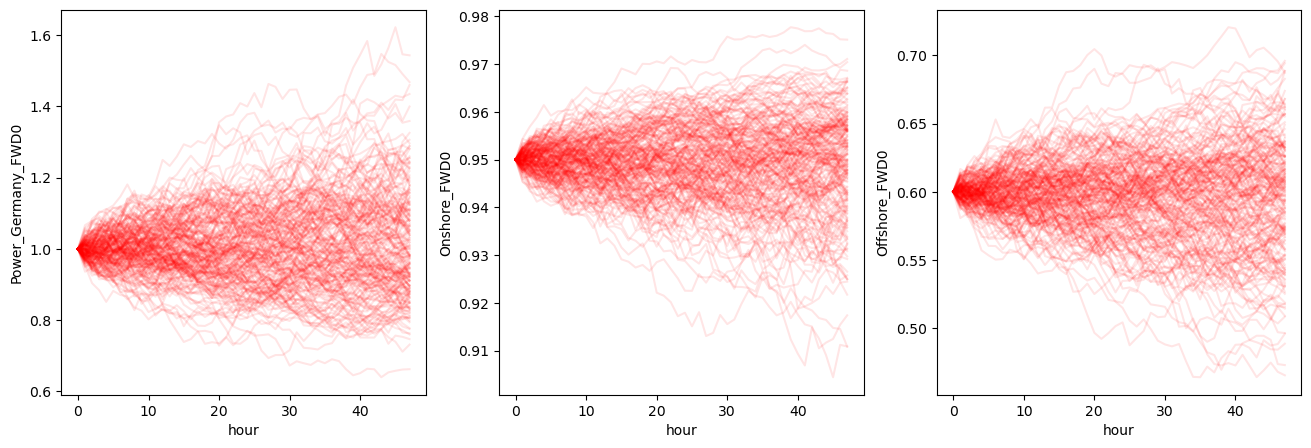

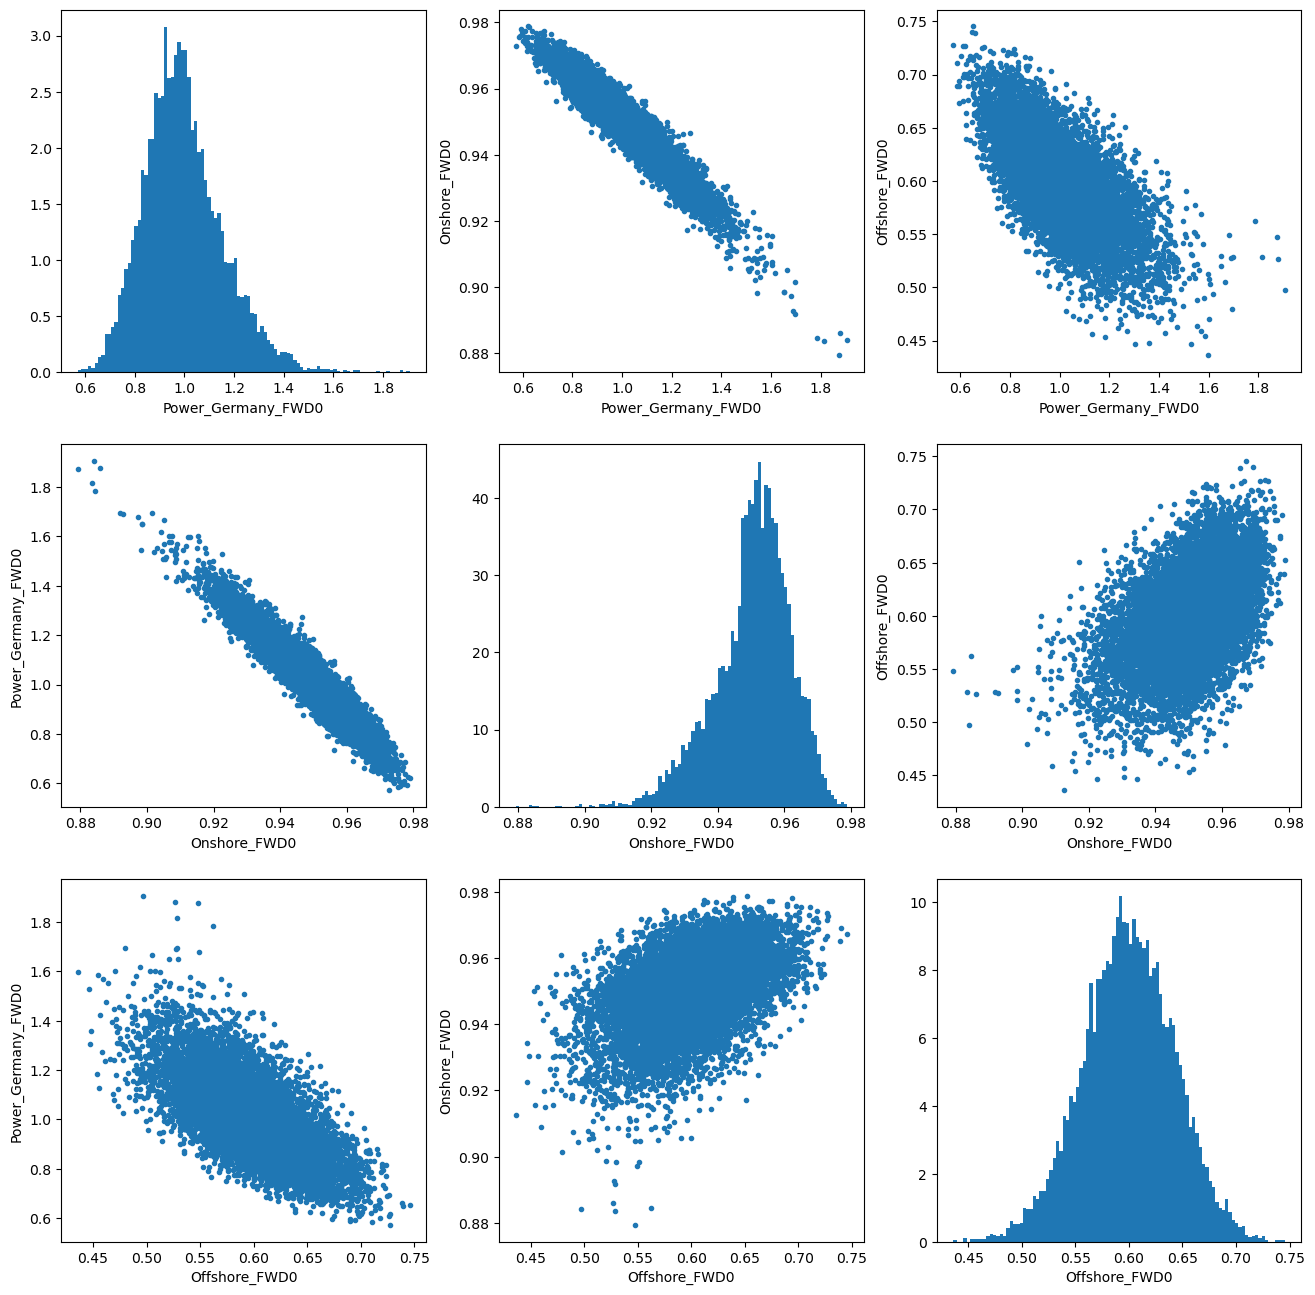

In [7]:
analysis.plot_paths(paths, None)

In [8]:
paths.get('Power_Germany_FWD0')[-1].mean()

0.9957418411935248

# Experiments

In [10]:
val_date = dt.datetime(2023,1,1)
strike = 1.0 #0.22
spec = GreenPPASpecification(udl='Power_Germany',
                            technology = 'Wind',
                             location = 'Onshore',
                             schedule = [val_date + dt.timedelta(days=2)], 
                             fixed_price=strike,
                             max_capacity = 1.0,
                             transaction_cost = 0.01)

In [11]:
repo = analysis.Repo('./experiments/')

In [12]:
repo.results.keys()

dict_keys(['a7b4461a3353337f96e58188db2087eb4cd90335', '75b5248ddc4b09a2e0e1194910fdc05bce4e3112', '91c071ac0f3214cd0e65e3e636755f80b8f8a5e7', 'c1ab45b4ad248d3cd152c78631088cc7f1c61ce4', '7ef18c826acc39073b98f0e630cc1861ee7504b0', '4a0107c15c4488cab77dec3325fcadc814a96384', 'd87b2c0fa3e81977f043dc1577f26386b2021d19', '9427c6498e63d664788050b6414b34fc698f4f61', '78ff582dac3d118dbf3efa26b7663b4762f756d6'])

In [13]:
pricing_results = repo.run(val_date, 
                           spec, model, 
                           initial_forecasts={'Onshore': [0.8],
                                        'Offshore': [0.6]},
                           power_fwd_prices=[1.0],
                           forecast_hours=[10, 14, 18],
                           additional_states=['Offshore'],
                           depth=3, 
                           nb_neurons=64, 
                           n_sims=100_000, 
                           regularization=0.0,
                           epochs=1, verbose=1,
                           tensorboard_logdir = 'logs/' + dt.datetime.now().strftime("%Y%m%dT%H%M%S"), 
                           initial_lr=5e-4,
                           decay_steps=8_000,
                           batch_size=100, decay_rate=0.8, seed=42)

3125/3125 [==============================] - 10s 2ms/step - loss: 0.0023


INFO:tensorflow:Assets written to: ./experiments//e92ab2d969af8e5ea81048ae0fd143e1ba39ac10//delta_model\assets


INFO:tensorflow:Assets written to: ./experiments//e92ab2d969af8e5ea81048ae0fd143e1ba39ac10//delta_model\assets


In [14]:
print(pricing_results)

# Analysis

In [15]:
repo = analysis.Repo('./experiments/')
# TODO: das muss wieder weg und in die serialisierung
for k,v in repo.results.items():
    v['val_date'] = dt.datetime.fromisoformat(v['val_date'])
    v['ppa_spec']['schedule'] = [dt.datetime.fromisoformat(k) for k in v['ppa_spec']['schedule']]

In [22]:
if False:
    to_delete = []
    for k,v in repo.results.items():
        #if (v['pricing_param']['loss']=='exponential_utility') and (v['pricing_param']['regularization']>=100):
        if v['pricing_param']['loss']=='expected_shortfall':
            to_delete.append(k)
    print('delete ',len(to_delete),'elements' )
    for d in to_delete:
        del repo.results[d]
        print(to_delete)
    repo.save()

KeyError: 'loss'

## HiPlot

In [16]:
#repo.plot_hiplot(conditions = [
#    ('pricing_param.nb_neurons', 32),
#    #('pricing_param.loss', 'exponential_utility'),
#    ('pricing_param.epochs', 400),
#    ('ppa_spec.max_capacity', 1.0)#(0.0,100.0))
#    ])
repo.plot_hiplot(conditions=[('pricing_param.loss', 'exponential_utility')])

ExperimentValidationError: Not a single datapoint

In [26]:
repo.get_model('c496c6b966dfa76e417ae139076ea55cac5311e5') #LinearDemandForwardModel

repo.get_hedge_model('c496c6b966dfa76e417ae139076ea55cac5311e5') #



In [6]:
if True:
    experiments = {}
    
    tmp={
        'ref_keys':[
            '35ada79703bc4f3c58b0233fcba96bbffb3f73e6',
            '15cf13e7ab2152f45e1bc91214d16ca2104cef38',
            'ff4d98cb75dfbaf971837f9047a61479f642cc17',
            '0c7b3d8619cbec57277a6b135ab2de62bb5872d9'
        ],
        'labels':{
            '35ada79703bc4f3c58b0233fcba96bbffb3f73e6':'utility, $\lambda$=5',
            '15cf13e7ab2152f45e1bc91214d16ca2104cef38':'utility, $\lambda$=10',
            'ff4d98cb75dfbaf971837f9047a61479f642cc17':'5%-ES',
            '0c7b3d8619cbec57277a6b135ab2de62bb5872d9':'20%-ES'
            
        }
    }
    experiments['ES vs utility'] = tmp
    
    tmp={
        'ref_keys': [
                    'f1d004c9c43277351b00a6a91e7f4dbadd51597a',
                    '746a7e2418d3fe45217fd8b5f3391067b886648f',
            
                    #'dadaf1ba18f7dfedc26113ab3ea2bd519ea81628',
                    #'93bbc9074c7f895857b9fac44ce0469cdd468d02',
            
                    'df37ae887383aa830afc9a6e7b118b501269dbf6',
                    'aab3c5e4c3d41deeee34ef0234a91a475921d581',
                     #'ae469115a6d35937c81f9a6e6a96a6b21d4b0af4',
                    #'97ce805620cd94f993d1d3dbaa2b0ded5243ab65',
                     
                     'd0d8954d364968010e1fd0c5e949d910f9af262d',
                     'b8ad4b249e35e6b5d34db160c88e4efaf96a069c',
                     
                    '35ada79703bc4f3c58b0233fcba96bbffb3f73e6',
                    '15cf13e7ab2152f45e1bc91214d16ca2104cef38',
                     #'ad385a1d8eebbaebbb3a1685ef3c9c8464d78814',
                     #'085fe6bc258ede3bc6a5de0818c2bca9fcc0ec00',
                     
                     #'7ec1b0ad66dc500e6ad7ceb12274c7b3bc1fab60',
                     #'ef415ad6ee8225d07a3e3236e28d6ba80cbee212',
                     
                     '3f3d764bd08199236ffed687dd3ba046d29ef2dc',
                     '65656cc08daa490db225de2dd9a68b86e473cf7f',
                     #'aa8f8123a4dd03f9ef3774341c0e4d608f765abb',
                     #'9ca7584636feeda4d39ebdefcd5f2c7dd3227cf0',
                     
                     
                    
                    'e64c95a0773728dc9207f7dbee219d293fe9690a',
                     'b2ca8460e7d34dedd4c835da1df166fad4ee4abc',
                     
                     'eb175bbca8e5d0ffdc2906b7c580858f6dca5ae3',
                     'b82bbb1dc8b22e3a5c14e343a1317bc38a480876',
                     #'084a6f109e235dbf54f84f5957f8e9339ddc0aae',
                     #'db484bd3a8c00e07e824c942ab30e2db012296f5',
            
                    '4c8d5dd024cc3efdd67293dc512ea66d6dabfdf5',
                   '04994fb40eb00f137cd0ff78182ef9e0f04de6e8',
            
                    '9331be5bbd0bfbcbfb372f17eec903bf1d06b9ea',
                   '4e7aed550f8c5f23022632a0dd6cfde0dcdfaf1c',
                    ],
        'labels': {
                    'f1d004c9c43277351b00a6a91e7f4dbadd51597a': 'max_cap: 0.0, lambda: 5',
                    '746a7e2418d3fe45217fd8b5f3391067b886648f': 'max_cap: 0.0, lambda: 10',
            
                    #'dadaf1ba18f7dfedc26113ab3ea2bd519ea81628': 'max_cap: 0.25, lambda: 5',
                    #'93bbc9074c7f895857b9fac44ce0469cdd468d02': 'max_cap: 0.25, lambda: 10',
            
                    'df37ae887383aa830afc9a6e7b118b501269dbf6': 'max_cap: 0.5, lambda: 5',
                    'aab3c5e4c3d41deeee34ef0234a91a475921d581': 'max_cap: 0.5, lambda: 10',
                   #'ae469115a6d35937c81f9a6e6a96a6b21d4b0af4': 'max_cap: 0.5, lambda: 15',
                    #'97ce805620cd94f993d1d3dbaa2b0ded5243ab65':'max_cap: 0.5, lambda: 20',
                   
                    'd0d8954d364968010e1fd0c5e949d910f9af262d': 'max_cap: 0.75, lambda: 5',
                    'b8ad4b249e35e6b5d34db160c88e4efaf96a069c': 'max_cap: 0.75, lambda: 10',
                   
                    '35ada79703bc4f3c58b0233fcba96bbffb3f73e6':'max_cap: 1.0, lambda: 5',
                    '15cf13e7ab2152f45e1bc91214d16ca2104cef38':'max_cap: 1.0, lambda: 10',
                   #'ad385a1d8eebbaebbb3a1685ef3c9c8464d78814':'max_cap: 1.0, lambda: 15',
                   #'085fe6bc258ede3bc6a5de0818c2bca9fcc0ec00': 'max_cap: 1.0, lambda: 20',
                   
                   #'7ec1b0ad66dc500e6ad7ceb12274c7b3bc1fab60': 'max_cap: 1.25, lambda: 5',
                   #'ef415ad6ee8225d07a3e3236e28d6ba80cbee212': 'max_cap: 1.25, lambda: 10',
                   
                   
                   '3f3d764bd08199236ffed687dd3ba046d29ef2dc': 'max_cap: 1.5, lambda: 5',
                   '65656cc08daa490db225de2dd9a68b86e473cf7f': 'max_cap: 1.5, lambda: 10',
                   #'aa8f8123a4dd03f9ef3774341c0e4d608f765abb': 'max_cap: 1.5, lambda: 15',
                   #'9ca7584636feeda4d39ebdefcd5f2c7dd3227cf0': 'max_cap: 1.5, lambda: 20',
                   
                   'e64c95a0773728dc9207f7dbee219d293fe9690a': 'max_cap: 1.75, lambda: 5',
                   'b2ca8460e7d34dedd4c835da1df166fad4ee4abc': 'max_cap: 1.75, lambda: 10',
                   
                   'eb175bbca8e5d0ffdc2906b7c580858f6dca5ae3':  'max_cap: 2.0, lambda: 5',
                   'b82bbb1dc8b22e3a5c14e343a1317bc38a480876': 'max_cap: 2.0, lambda: 10',
                   #'084a6f109e235dbf54f84f5957f8e9339ddc0aae': 'max_cap: 2.0, lambda: 15',
                  #'db484bd3a8c00e07e824c942ab30e2db012296f5': 'max_cap: 2.0, lambda: 20'
            
                    '4c8d5dd024cc3efdd67293dc512ea66d6dabfdf5':  'max_cap: 5.0, lambda: 5',
                   '04994fb40eb00f137cd0ff78182ef9e0f04de6e8': 'max_cap: 5.0, lambda: 10',
            
                    '9331be5bbd0bfbcbfb372f17eec903bf1d06b9ea':  'max_cap: 10.0, lambda: 5',
                   '4e7aed550f8c5f23022632a0dd6cfde0dcdfaf1c': 'max_cap: 10.0, lambda: 10',
                  }
    }
    experiments['utility pricing'] = tmp
    
    # models with different regularization coefficients, n_forecast_hours = 3
    tmp = {
    'ref_keys': [ #'3e614fd22e85a35d8060f6403e528b5776a692a7',
                 #'cf6371ae0690b16fed4b3d3057a3b79314c48c9a',
                 #'5d4f2fe9ea61863af8badfb2817d3918b0d6410b',
                 'b434e763fbdeebab9432ebe72f6920f46436cd40',
                 '4bde61a23e04048923efa2468c1fbe762f6e3740',
                 '03a8c1e2c7c3b21dc54f401faef65a7fe034568b'
                   ],
        'labels': {'3e614fd22e85a35d8060f6403e528b5776a692a7': '0.0',
                   'cf6371ae0690b16fed4b3d3057a3b79314c48c9a': '0.2',
                   '5d4f2fe9ea61863af8badfb2817d3918b0d6410b': '0.5',
                   'b434e763fbdeebab9432ebe72f6920f46436cd40': 'utility, 10',
                   '4bde61a23e04048923efa2468c1fbe762f6e3740': 'utility, 20',
                   '03a8c1e2c7c3b21dc54f401faef65a7fe034568b': 'utility, 50'
                   
                  },
        'description':'varying regularization term for problem with three forecast hours [10,14,18]',
    }
    experiments['varying_regularization']=tmp
    
    tmp = {
    'ref_keys': [ 'ca7f4aeb88d71908ad8fe6e9ebc16b096ca12af3',
                   'c2ec661955a56cc70bb037fe86fdeedd5d9bdb70',
                 'd6c174a31171957da8a4392d2911f3238f936144'
                   ],
    'labels': {'ca7f4aeb88d71908ad8fe6e9ebc16b096ca12af3': '0.0',
            'c2ec661955a56cc70bb037fe86fdeedd5d9bdb70': '0.2',
               'd6c174a31171957da8a4392d2911f3238f936144': '0.5'
                  },
        'description':'varying regularization term for problem with three forecast hours [10,14,18] for ITM (power forward = 0.8)',
    }
    experiments['varying_regularization_ITM']=tmp
    
    tmp = {
    'ref_keys': [ '637976c7970c035afe479a7ca8ee9ebb2e041e71',
                   'e75d32a25a83a936140c58856fc5737675a04edc',
                 '61c60c47b5751b7a1887dc8edaea4bcc1b7f6ff0'
                   ],
    'labels': {'637976c7970c035afe479a7ca8ee9ebb2e041e71': '0.0',
            'e75d32a25a83a936140c58856fc5737675a04edc': '0.2',
               '61c60c47b5751b7a1887dc8edaea4bcc1b7f6ff0':'0.5'
                  },
        'description':'varying regularization term for problem with three forecast hours [10,14,18] for OTM (power forward = 1.2)',
    }
    experiments['varying_regularization_OTM']=tmp
    
    tmp = {
    'ref_keys': [ '2e910288fdcc2dc2956a04a8195834aaf8ddfee0',
                   'ab2726e8bb416f71a2d0324d7e2b0ce37f1f0d98',
                 '3e614fd22e85a35d8060f6403e528b5776a692a7'
                   ],
    'labels': {'2e910288fdcc2dc2956a04a8195834aaf8ddfee0': '0.2',
            'ab2726e8bb416f71a2d0324d7e2b0ce37f1f0d98': '0.5',
               '3e614fd22e85a35d8060f6403e528b5776a692a7':'0.8'
                  },
        'description':'varying regularization term for problem with three forecast hours [10,14,18] for OTM (power forward = 1.2)',
    }
    experiments['varying_forecast']=tmp
    
    tmp = {
    'ref_keys': [ 'ff4d98cb75dfbaf971837f9047a61479f642cc17',
                   'bd1f2658c3eef9340c9d611303ecfa4136eb3ee3',
                 '0c7b3d8619cbec57277a6b135ab2de62bb5872d9'
                   ],
    'labels': {'ff4d98cb75dfbaf971837f9047a61479f642cc17': '5%',
               'bd1f2658c3eef9340c9d611303ecfa4136eb3ee3': '10%',
               '0c7b3d8619cbec57277a6b135ab2de62bb5872d9': '20%'
                  },
        'description':'',
    }
    experiments['expected_shortfall']=tmp
    
    
if False: 
    experiments = {}
    # models with different regularization coefficients, n_forecast_hours = 3
    tmp = {
    'ref_keys': [ 
                    'b4c462d6882475a84a754bb671780e9916c8d9ff',
                    'a816594ff6f8f489bb83feb919c9aa4626f1519f',
                    'bd7d72be86e9c12129568ce34e137dc1b5baaa51'
                   ],
        'labels': {'b4c462d6882475a84a754bb671780e9916c8d9ff': '0.0', 
                  'a816594ff6f8f489bb83feb919c9aa4626f1519f': '0.1', 
                  'bd7d72be86e9c12129568ce34e137dc1b5baaa51': '0.2', 
                  },
        'description':'varying regularization term for problem with three forecast hours [10,14,18]',
    }
    experiments['varying_regularization']=tmp
    tmp = {
    'ref_keys': [ 
                    '8c00afe49241f09263678c80fab1c6bfc0435cfb',
                    '18e548c018e595b86c8d1f8832dbd0311fd742ef',
                    '4f379afb340619d3e5c532e8f3c04cc2584bbe4e',
                    '68e6fb620a2909dfa7875161128a0f59802be7fc'
                   ],
        'labels': {'8c00afe49241f09263678c80fab1c6bfc0435cfb': '0.0', 
                  '18e548c018e595b86c8d1f8832dbd0311fd742ef': '0.1', 
                  '4f379afb340619d3e5c532e8f3c04cc2584bbe4e': '0.2', 
                   '68e6fb620a2909dfa7875161128a0f59802be7fc' : '0.5'
                  },
        'description':'varying regularization term for problem with three forecast hours [10,14,18] and a forecast of 0.5',
    }
    experiments['varying_regularization_forecast_0.5']=tmp
if False: #old stuff    
    experiments = {}
    # models with different regularization coefficients, n_forecast_hours = 3
    tmp = {
    'ref_keys': [ 
                    #'c977969a206844c4a79848df3db0ccd09bcd8ee7',
                     #'1aedf203216342f2dea183af9fcdda341e31337a', 
                    '417bfb85f4dba1ff37f76ff7d5fdb6ca2e0d2ea8',
                    'c679f5903b066db828d211ea1c48f03395f76d21', 
                    'e351f639d6c035c0a4cfeff4dd3ebd43d39f9932'
                   ],
        'labels': {'417bfb85f4dba1ff37f76ff7d5fdb6ca2e0d2ea8': '0.0', 
                  '1aedf203216342f2dea183af9fcdda341e31337a': '0.1', 
                  'c977969a206844c4a79848df3db0ccd09bcd8ee7': '0.25', 
                  'c679f5903b066db828d211ea1c48f03395f76d21': '0.5', 
                  'e351f639d6c035c0a4cfeff4dd3ebd43d39f9932': '1.0'},
        'description':'varying regularization term for problem with three forecast hours [10,14,18]',
    }
    experiments['varying_regularization']=tmp
    experiments['zero_wind_volatility'] ={'ref_keys': ['489bf539cf645622b5a1fa29392a68e895b84f5b'], 
                                          'labels':{'489bf539cf645622b5a1fa29392a68e895b84f5b':'0.0'}, 
                                          'description':'zero wind wolatility (perfect replication by static hedge)'
                                         }

    experiments['strikes'] = { 'ref_keys': ['9c8b7a3a50ad27fc9be89c9324c074cebb86b4a9',  '417bfb85f4dba1ff37f76ff7d5fdb6ca2e0d2ea8', '1daab358760e5f2dbf34bc6600ba41ae02020493'],
                             'labels': {'9c8b7a3a50ad27fc9be89c9324c074cebb86b4a9':'0.9', 
                                      '417bfb85f4dba1ff37f76ff7d5fdb6ca2e0d2ea8':'1.0',
                                       '1daab358760e5f2dbf34bc6600ba41ae02020493': '1.1'},                          
                                  'description':'different strikes'     }

    experiments['forecasts'] ={'ref_keys':['7525471af6019d720fe596c36a689a8bcbaf6c3b', 
                                           '21b26f95807cefd400cd467b94b890f17e729395',
                                          '417bfb85f4dba1ff37f76ff7d5fdb6ca2e0d2ea8',
                                          '643e9896e2240d5815bbb9c9520215ae766a3447'], 
                               'labels':{'7525471af6019d720fe596c36a689a8bcbaf6c3b':'0.2', 
                                        '21b26f95807cefd400cd467b94b890f17e729395':'0.5',
                                        '417bfb85f4dba1ff37f76ff7d5fdb6ca2e0d2ea8':'0.8',
                                         '643e9896e2240d5815bbb9c9520215ae766a3447':'0.9'
                                        }}



In [9]:
if False:
    t1 = repo.results['d277eccaf811eecc8775716516f55f71634e68fa']#['pricing_param']#['power_fwd_prices'][0]#['model']
    t2 = repo.results['56071ff4ed5173b5d973d457908cfc0cdbfee617']
    ddiff = deepdiff.DeepDiff(t1,t2)
    pprint.pprint(ddiff)
#repo.results['d277eccaf811eecc8775716516f55f71634e68fa']
#repo.select(conditions = [('pricing_param.nb_neurons', 32)])

In [7]:
experiment = 'varying_regularization' #'varying_regularization_forecast_0.5' #'varying_regularization' expected_shortfall
ref_keys = experiments[experiment]['ref_keys']
labels = experiments[experiment]['labels']
labels_T = {k:v for v,k in labels.items()}
#hedge_models = {k: repo.get_hedge_model(k) for k in ref_keys}
#specs = {k: GreenPPASpecification.from_dict(repo.results[k]['ppa_spec']) for k in ref_keys}
result_dir = 'results/'+experiment+'/'

## Utility Vs ES

In [10]:
experiment = 'ES vs utility' #'varying_regularization_forecast_0.5' #'varying_regularization' expected_shortfall
ref_keys = experiments[experiment]['ref_keys']
labels = experiments[experiment]['labels']
labels_T = {k:v for v,k in labels.items()}
sim_results, forecast_points, hedge_models, specs, paths, pnl = setup(ref_keys, ref_key_volume_hedge=labels_T['5%-ES'])

simulate paths
load models and specs


2023-11-20 14:05:39.197086: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-11-20 14:05:39.197127: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: meray
2023-11-20 14:05:39.197138: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: meray
2023-11-20 14:05:39.197239: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.78.1
2023-11-20 14:05:39.197272: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.78.1
2023-11-20 14:05:39.197282: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 525.78.1
2023-11-20 14:05:39.197970: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in perfor

compute pnl
1.0
1.0
1.0
1.0


### PnL Distributions

In [42]:
pnl.keys()

dict_keys(['volume_hedge', 'no_hedge', 'static_volume_hedge', '35ada79703bc4f3c58b0233fcba96bbffb3f73e6', '15cf13e7ab2152f45e1bc91214d16ca2104cef38', 'ff4d98cb75dfbaf971837f9047a61479f642cc17', '0c7b3d8619cbec57277a6b135ab2de62bb5872d9'])

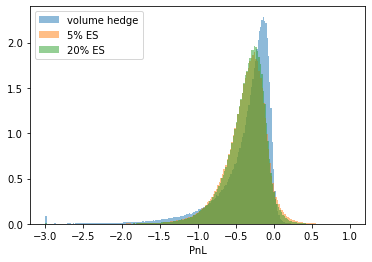

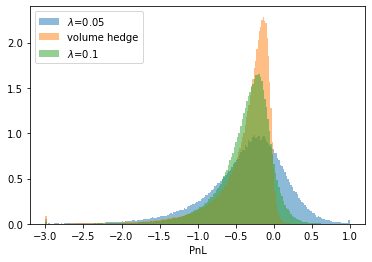

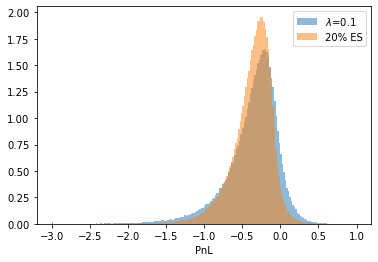

In [49]:
key = 'volume_hedge'
plt.hist(np.clip(100*pnl[key], -3,1), bins=200, label='volume hedge', density=True, alpha=0.5)
key = '5%-ES'
key = labels_T[key]
plt.hist(np.clip(100*pnl[key], -3,1), bins=200, label='5% ES', density=True, alpha=0.5);
key = '20%-ES'
key = labels_T[key]
plt.hist(np.clip(100*pnl[key], -3,1), bins=200, label='20% ES', density=True, alpha=0.5)
plt.legend()
plt.xlabel('PnL')
plt.savefig('results/utility_vs_es/es_hist.png', dpi=800)

plt.figure()
key = 'utility, $\\lambda$=5'
key = labels_T[key]
plt.hist(np.clip(100*pnl[key], -3,1), bins=200, label='$\\lambda$=0.05', density=True, alpha=0.5);
key = 'volume_hedge'
plt.hist(np.clip(100*pnl[key], -3,1), bins=200, label='volume hedge', density=True, alpha=0.5)
key = 'utility, $\\lambda$=10'
key = labels_T[key]
plt.hist(np.clip(100*pnl[key], -3,1), bins=200, label='$\\lambda$=0.1', density=True, alpha=0.5)
plt.legend();
plt.xlabel('PnL')
plt.savefig('results/utility_vs_es/utility_hist.png', dpi=800)
plt.figure()
#key = 'volume_hedge'
key = 'utility, $\\lambda$=10'
key = labels_T[key]
plt.hist(np.clip(100*pnl[key], -3,1), bins=200, label='$\\lambda$=0.1', density=True, alpha=0.5);
#key = 'no_hedge'
key='20%-ES'
key = labels_T[key]
plt.hist(np.clip(100*pnl[key], -3,1), bins=200, label='20% ES', density=True, alpha=0.5)
plt.legend()
plt.savefig('results/utility_vs_es/utility_vs_es_hist.png', dpi=800)
plt.xlabel('PnL');

Text(0, 0.5, 'PnL 5% ES')

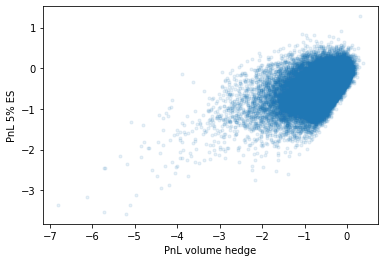

In [38]:
key = 'volume_hedge'
pnl1 = 100*pnl[key]
key = '5%-ES'
key = labels_T[key]
pnl2 = 100*pnl[key]
plt.plot(pnl1,pnl2,'.', alpha=0.1)
plt.xlabel('PnL volume hedge')
plt.ylabel('PnL 5% ES')
#plt.xlim(-7,0.5)
#plt.ylim(-7,0.5);

In [28]:
(paths[labels_T['5%-ES']]['Power_Germany_FWD0']-paths[labels_T['20%-ES']]['Power_Germany_FWD0']).mean()

0.0

### PnL Statistics

In [68]:
df = compute_statistics(pnl, labels)
#df=df.reset_index()
pd.options.display.float_format = '{:,.4f}'.format
df
#print(df.to_latex())

,mean,var,p-skewness,5% ES,20% ES,"utility, 0.05","utility, 0.1"
name,,,,,,,
volume_hedge,-0.3692,0.3794,-0.8895,-1.5659,-0.9549,1.0188,1.0384
no_hedge,-0.5841,11.2728,0.0880,-22.9974,-15.9770,1.2014,1.9338
"utility, $\lambda$=5",-0.3624,0.5263,-0.4243,-1.7572,-1.1608,1.0186,1.0384
"utility, $\lambda$=10",-0.3667,0.3497,-0.5570,-1.3567,-0.8998,1.0187,1.0380
5%-ES,-0.3720,0.2756,-0.4457,-1.1007,-0.7871,1.0189,1.0383
20%-ES,-0.3715,0.2686,-0.5124,-1.1026,-0.7796,1.0188,1.0382


In [69]:
labels_T.keys()

dict_keys(['utility, $\\lambda$=5', 'utility, $\\lambda$=10', '5%-ES', '20%-ES'])

### Delta

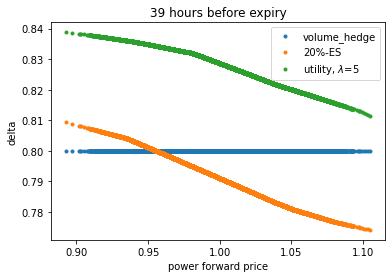

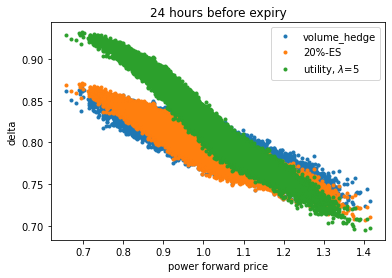

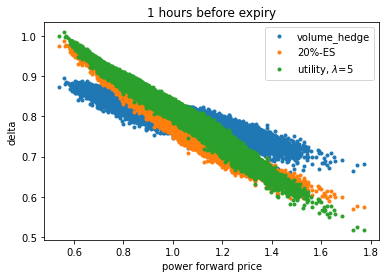

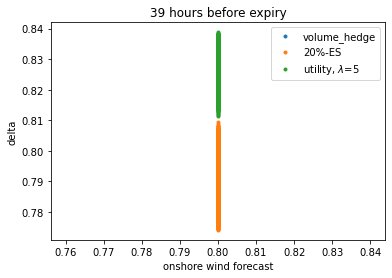

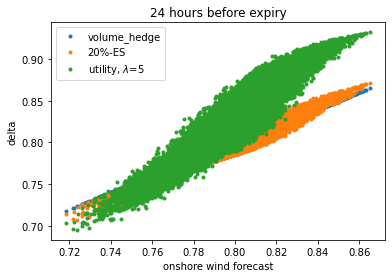

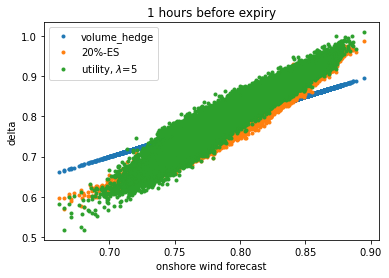

In [102]:
for t in [9, 24, 47]:
    plt.figure()
    # volume hedge
    key = '20%-ES'
    key = labels_T[key]
    plt.plot(paths[key]['Power_Germany_FWD0'][t,:], paths[key]['Onshore_FWD0'][t,:],'.', label='volume_hedge', alpha=1.0)
    key = '20%-ES'
    key = labels_T[key]
    delta = -hedge_models[key].compute_delta(paths[key], t).reshape((-1,))
    v = paths[key]['Power_Germany_FWD0'] #Power_Germany_FWD0
    plt.plot(v[t,:], delta,'.', label=labels[key], alpha=1.0)
    #plt.figure()
    key = 'utility, $\lambda$=5'
    key = labels_T[key]
    delta = -hedge_models[key].compute_delta(paths[key], t).reshape((-1,))
    v = paths[key]['Power_Germany_FWD0']
    plt.plot(v[t,:], delta,'.', label=labels[key], alpha=1.0)
    plt.legend()
    plt.xlabel('power forward price')
    plt.ylabel('delta')
    title = str(48-t)+' hours before expiry'
    plt.title(title)
    plt.savefig('results/utility_vs_es/delta_'+str(48-t)+'.png', dpi=800)

for t in [9, 24, 47]:
    plt.figure()
    # volume hedge
    key = '20%-ES'
    key = labels_T[key]
    plt.plot(paths[key]['Onshore_FWD0'][t,:], paths[key]['Onshore_FWD0'][t,:],'.', label='volume_hedge', alpha=1.0)
    key = '20%-ES'
    key = labels_T[key]
    delta = -hedge_models[key].compute_delta(paths[key], t).reshape((-1,))
    v = paths[key]['Onshore_FWD0'] #Power_Germany_FWD0
    plt.plot(v[t,:], delta,'.', label=labels[key], alpha=1.0)
    #plt.figure()
    key = 'utility, $\lambda$=5'
    key = labels_T[key]
    delta = -hedge_models[key].compute_delta(paths[key], t).reshape((-1,))
    v = paths[key]['Onshore_FWD0']
    plt.plot(v[t,:], delta,'.', label=labels[key], alpha=1.0)
    plt.legend()
    plt.xlabel('onshore wind forecast')
    plt.ylabel('delta')
    title = str(48-t)+' hours before expiry'
    plt.title(title)
    plt.savefig('results/utility_vs_es/delta_onshore_'+str(48-t)+'.png', dpi=800)




### Delta Projections

In [42]:
labels_T.keys()

dict_keys(['utility, $\\lambda$=5', 'utility, $\\lambda$=10', '5%-ES', '20%-ES'])

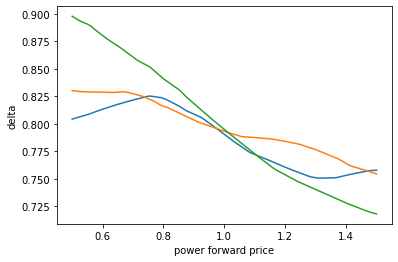

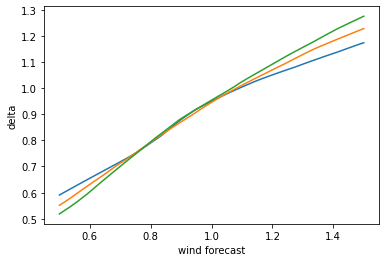

In [45]:
key = '20%-ES'
key = labels_T[key]
for t in [10,25,40]:
    power_fwd = np.linspace(0.5,1.5, 100)
    dummy_paths = {'Offshore_FWD0': np.zeros((48, power_fwd.shape[0]))}
    dummy_paths['Power_Germany_FWD0'] = np.tile(power_fwd,(48,1))
    dummy_paths['Onshore_FWD0'] = 0.8*np.ones(dummy_paths['Power_Germany_FWD0'].shape )
    delta = -hedge_models[key].compute_delta(dummy_paths, t).reshape((-1,))
    plt.plot(power_fwd, delta)
plt.xlabel('power forward price')
plt.ylabel('delta')
plt.figure()
for t in [10,25,40]:
    power_fwd = np.linspace(0.5,1.5, 100)
    dummy_paths = {'Offshore_FWD0': np.zeros((48, power_fwd.shape[0]))}
    dummy_paths['Onshore_FWD0'] = np.tile(power_fwd,(48,1))
    dummy_paths['Power_Germany_FWD0'] = 1.0*np.ones(dummy_paths['Offshore_FWD0'].shape )
    delta = -hedge_models[key].compute_delta(dummy_paths, t).reshape((-1,))
    plt.plot(power_fwd, delta)
    plt.xlabel('wind forecast')
    plt.ylabel('delta');

In [ ]:
key = '20%-ES'
key = labels_T[key]
dummy_paths = {'Offshore_FWD0': np.zeros((48, 10)),Power_Germany_FWD0}

## Utility indifference pricing

In [12]:
experiment = 'utility pricing' #'varying_regularization_forecast_0.5' #'varying_regularization' expected_shortfall
ref_keys = experiments[experiment]['ref_keys']
labels = experiments[experiment]['labels']
labels_T = {k:v for v,k in labels.items()}
sim_results, forecast_points, hedge_models, specs, paths, pnl = setup(ref_keys, ref_key_volume_hedge=labels_T['max_cap: 1.0, lambda: 5'])

simulate paths
load models and specs


2023-11-11 07:21:22.082712: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-11-11 07:21:22.082797: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: meray
2023-11-11 07:21:22.082819: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: meray
2023-11-11 07:21:22.082966: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.78.1
2023-11-11 07:21:22.083045: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.78.1
2023-11-11 07:21:22.083067: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 525.78.1
2023-11-11 07:21:22.084531: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in perfor

compute pnl
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


### Model paths

In [42]:
sim_results['f1d004c9c43277351b00a6a91e7f4dbadd51597a'].keys()

{'Offshore_FWD0', 'Onshore_FWD0', 'Power_Germany_FWD0', 'Wind_Germany_FWD0'}

### PnL Distributions

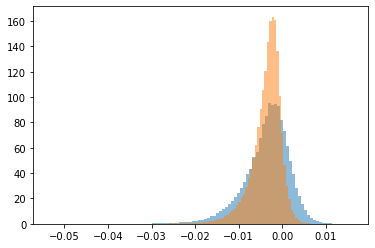

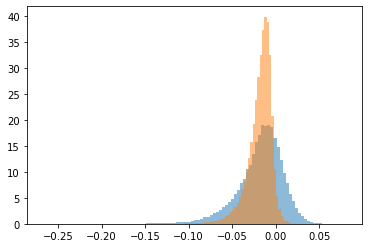

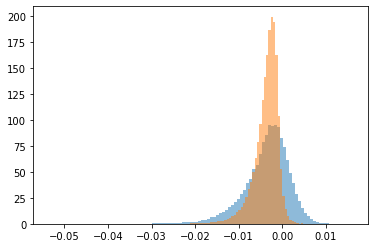

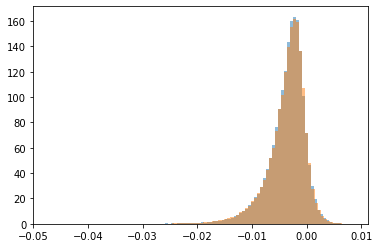

In [40]:
key = 'max_cap: 1.0, lambda: 5'
key = labels_T[key]
plt.hist(pnl[key], bins=100, label='5', density=True, alpha=0.5)
key = 'max_cap: 1.0, lambda: 10'
key = labels_T[key]
plt.hist(pnl[key], bins=100, label='10', density=True, alpha=0.5);

plt.figure()
key = 'max_cap: 1.0, lambda: 5'
key = labels_T[key]
plt.hist(5.0*pnl[key], bins=100, label='5', density=True, alpha=0.5)
key = 'max_cap: 5.0, lambda: 5'
key = labels_T[key]
plt.hist(pnl[key], bins=100, label='10', density=True, alpha=0.5);

plt.figure()
key = 'max_cap: 1.0, lambda: 5'
key = labels_T[key]
plt.hist(pnl[key], bins=100, label='5', density=True, alpha=0.5)
key = 'max_cap: 5.0, lambda: 5'
key = labels_T[key]
plt.hist(pnl[key]/5.0, bins=100, label='10', density=True, alpha=0.5);

plt.figure()
key = 'max_cap: 1.0, lambda: 10'
key = labels_T[key]
plt.hist(pnl[key], bins=100, label='5', density=True, alpha=0.5)
key = 'max_cap: 2.0, lambda: 5'
key = labels_T[key]
plt.hist(pnl[key]/2.0, bins=100, label='10', density=True, alpha=0.5);

### Price-Dependency on Maximal Capacity

In [15]:
pnl_stat = compute_statistics(pnl, labels)

In [26]:
prices = {'maximum capacity': [0.5,  1.0,  2.0, 5.0, 10.0]}
for l in [5, 10]:
    p = []
    p_normed = []
    i = 0
    for max_cap in prices['maximum capacity']:
        try:
            utility = pnl_stat.loc['max_cap: ' + str(max_cap)+', lambda: '+str(l), 'utility, '+ str(l/100) ]
            #utility_0 = pnl_stat.loc['max_cap: 0, lambda: '+str(l), 'utility, '+ str(l/100) ]
            p.append(np.log(utility)/(l/100))
            p_normed.append(p[-1]/max_cap)
        except:
            #print(pnl_stat.loc['max_cap: ' + str(max_cap)+', lambda: '+str(l), 'utility, '+ str(l/100) ])
            p.append(None)
    prices[l] = p
    prices[str(l) + ' normed'] =p_normed
df_prices = pd.DataFrame(prices)
df_prices

,maximum capacity,5,5 normed,10,10 normed
0,0.5,0.180799,0.361599,0.183713,0.367426
1,1.0,0.367350,0.367350,0.371599,0.371599
2,2.0,0.743211,0.371606,0.753609,0.376804
3,5.0,1.896365,0.379273,1.953677,0.390735
4,10.0,4.197502,0.419750,103.391429,10.339143


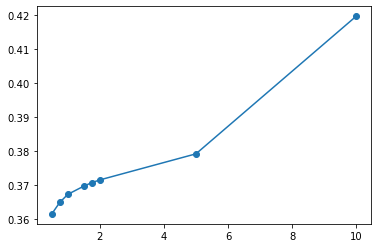

In [25]:
plt.plot(df_prices.values[:,0], df_prices.values[:,2],'-o')
#plt.plot(df_prices.values[:,0], df_prices.values[:,2],'-o');
#plt.plot(df_prices.values[:,0], df_prices.values[:,3],'-o')
#plt.plot(df_prices.values[3][1:],'-o')


### Delta-Dependency on Maximal Capacity

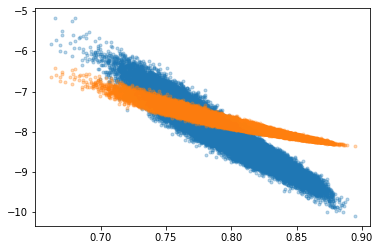

In [38]:
t = -2
key = 'max_cap: 1.0, lambda: 5'
key = labels_T[key]
delta = hedge_models[key].compute_delta(paths[key], t).reshape((-1,))
v = paths[key]['Onshore_FWD0'] #Power_Germany_FWD0
plt.plot(v[t,:], 10.0*delta,'.', label=labels[key], alpha=0.3)

key = 'max_cap: 10.0, lambda: 5'
key = labels_T[key]
delta = hedge_models[key].compute_delta(paths[key], t).reshape((-1,))
v = paths[key]['Onshore_FWD0']
plt.plot(v[t,:], delta,'.', label=labels[key], alpha=0.3)


In [75]:
paths[key].keys()

dict_keys(['Power_Germany_FWD0', 'Onshore_FWD0', 'Offshore_FWD0'])

## Model paths

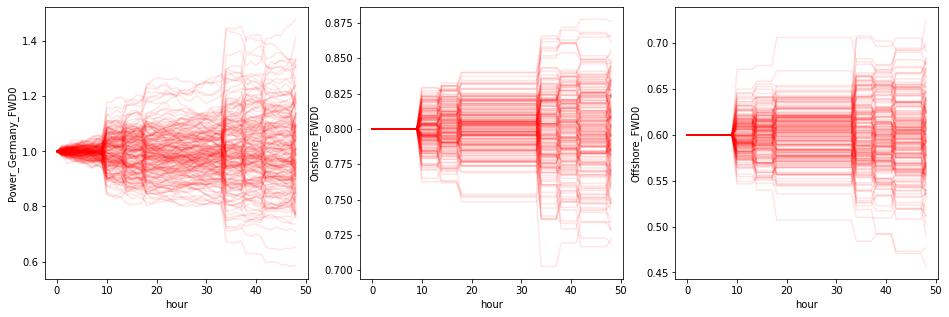

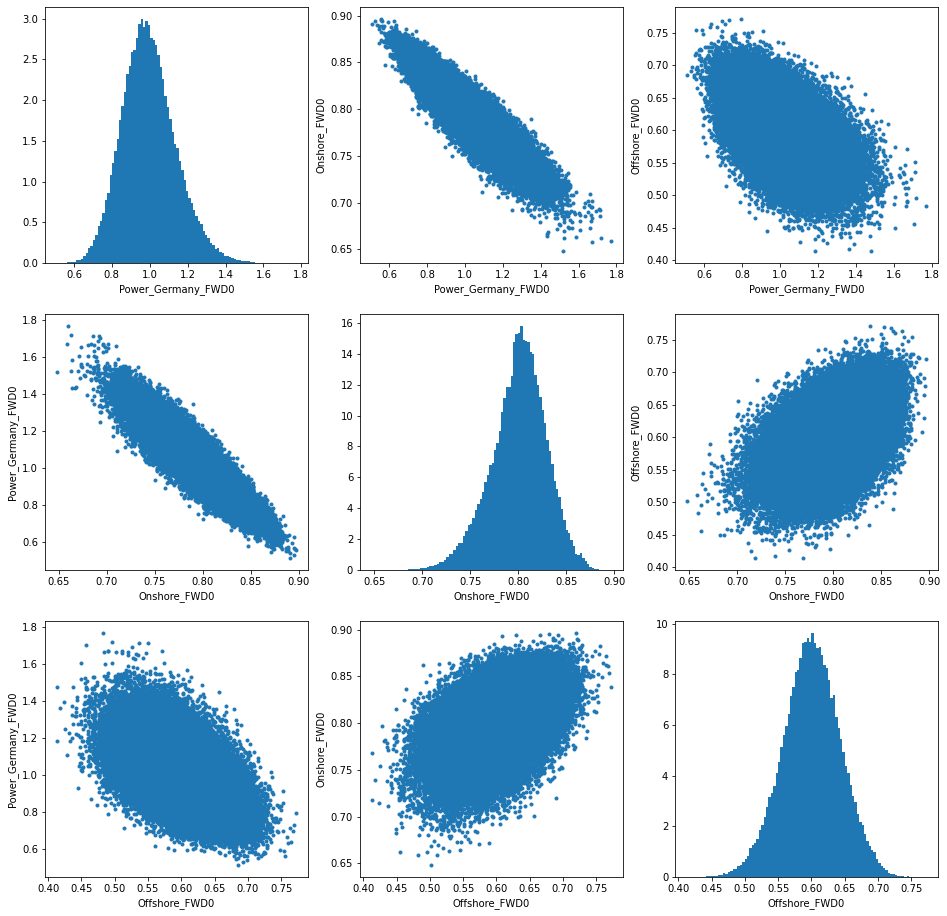

In [107]:
sim_results ={}
forecast_points={}
for k in ref_keys:
    sim_results[k], forecast_points[k] = repo.simulate_model(k, n_sims=100_000)
    
analysis.plot_paths(sim_results[ref_keys[0]], forecast_points[ref_keys[0]], result_dir)

## Hedge PnL

In [108]:
paths = {k:{l:sim_results[k].get(l, forecast_points[k]) for l in ['Power_Germany_FWD0', 'Onshore_FWD0', 'Offshore_FWD0']} for k in ref_keys}
pnl = {
    'volume_hedge': compute_volume_hedge_pnl(paths[ref_keys[0]], specs[ref_keys[0]]),
      'no_hedge': compute_no_hedge_pnl(paths[ref_keys[0]], specs[ref_keys[0]]),
    'static_volume_hedge':compute_static_volume_hedge_pnl(paths[ref_keys[0]], specs[ref_keys[0]])
      }
for k,v in hedge_models.items():
    paths[k]
    specs[k]
    labels[k]
    pnl[labels[k]] = compute_pnl(v, paths[k], specs[k])#specs['ec202973a34dfc5b71a86e0e7b2209a62c29b6a1'])#
#pnl['pnl_static_volume_hedge']= compute_static_volume_hedge_pnl(paths, spec)

1.0
1.0
1.0


In [124]:
if False:
    import tensorflow as tf
    model = hedge_models['24a19e98a0e338e6d0918ef48edcb1f4e00c0fd9']
    p=model._create_inputs(paths['24a19e98a0e338e6d0918ef48edcb1f4e00c0fd9'])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0)
    model.compile(optimizer, loss=model.custom_loss)
    model._loss='exponential_utility'
    model.evaluate(p, np.zeros(10_000))
    model._loss
    pred = model.predict(p)

In [15]:
#del pnl['pnl_static_volume_hedge']
#del pnl['1.0']
#del pnl['pnl_volume_hedge']

### Statistics

In [109]:
pnl_stat = {'name':[], 'mean': [], 'var':[],'p-skewness':[], '20%': [], '5%':[], '10%':[], '5% ES':[], '10% ES':[], '20% ES':[], 
           'utility, 0.1': [], 'utility, 0.5': []}
for k,v in pnl.items():
    if ( k == 'static_volume_hedge'):# or (k==): # (k == 'no_hedge') or
        continue
    v_ = 100.0*v
    pnl_stat['name'].append(k)
    pnl_stat['mean'].append(np.mean(v_))
    pnl_stat['var'].append(np.sqrt(np.var(v_)))
    pnl_stat['p-skewness'].append( 3.0*(v_.mean()-np.median(v_))/v_.std())
    
    tmp = np.percentile(v_, 10)
    pnl_stat['10%'].append(tmp)
    tmp = v_[v_<tmp].mean()
    pnl_stat['10% ES'].append(tmp) 
    
    tmp = np.percentile(v_, 20)
    pnl_stat['20%'].append(tmp)
    tmp = v_[v_<tmp].mean()
    pnl_stat['20% ES'].append(tmp)
    tmp = np.percentile(v_, 5)
    pnl_stat['5%'].append(tmp)
    tmp = v_[v_<tmp].mean()
    pnl_stat['5% ES'].append(tmp)
    
    pnl_stat['utility, 0.1'].append(np.mean(np.exp(-0.1*v_)))
    pnl_stat['utility, 0.5'].append( np.mean(np.exp(-0.5*v_)))
    
pnl_stat = pd.DataFrame(pnl_stat)
pnl_stat#.to_latex(float_format="{:0.3f}".format)

,name,mean,var,p-skewness,20%,5%,10%,5% ES,10% ES,20% ES,"utility, 0.1","utility, 0.5"
0,volume_hedge,-0.367972,0.380545,-0.880494,-0.543914,-1.087128,-0.803198,-1.565406,-1.246482,-0.951698,1.038265,1.229867
1,no_hedge,-0.613481,11.250506,0.097671,-10.049430,-18.580167,-14.756735,-22.875742,-19.685455,-15.947874,1.930105,144680.952623
2,"utility, 10",-0.367114,0.330088,-0.595768,-0.567506,-0.976964,-0.771549,-1.308181,-1.084684,-0.870992,1.037969,1.219771
3,"utility, 20",-0.368530,0.292894,-0.597649,-0.551582,-0.909428,-0.729048,-1.198061,-1.003232,-0.816547,1.037993,1.216538
4,"utility, 50",-0.367361,0.304593,-0.597390,-0.555252,-0.928598,-0.739519,-1.237868,-1.030689,-0.833702,1.037909,1.217119


In [113]:
np.log(1.217119)/0.5
np.log(1.037969)/0.1

0.37265919172484235

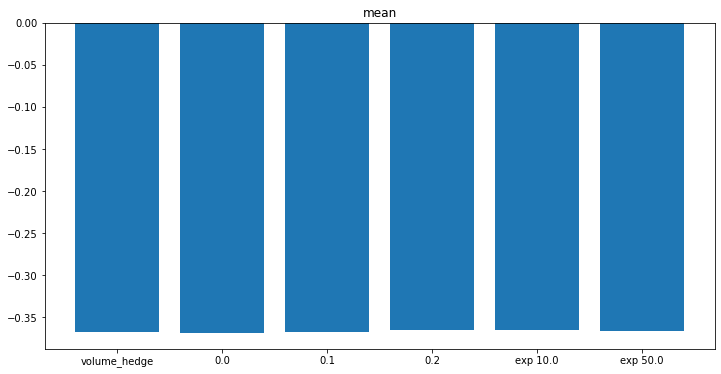

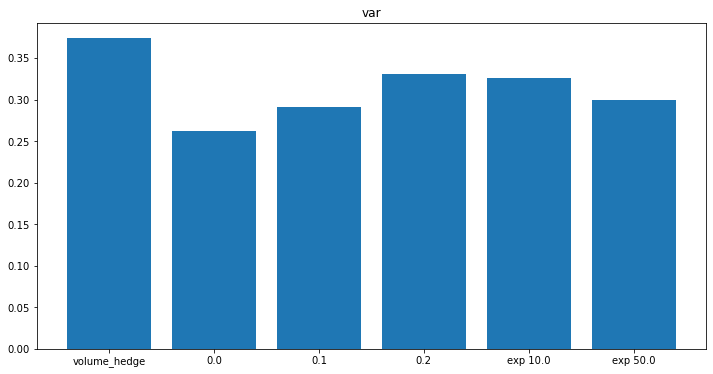

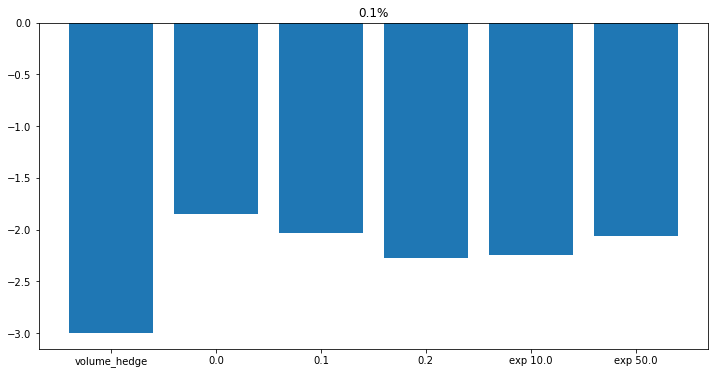

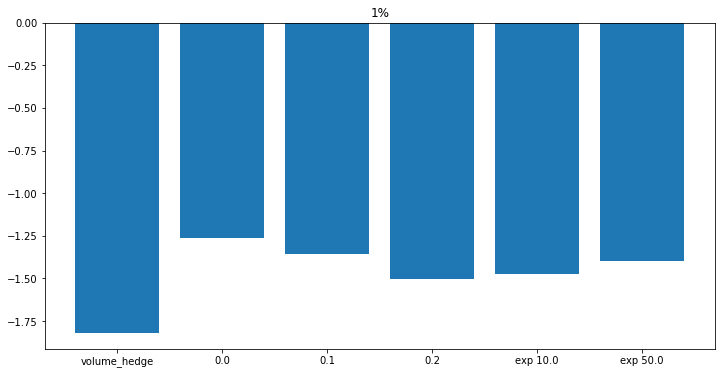

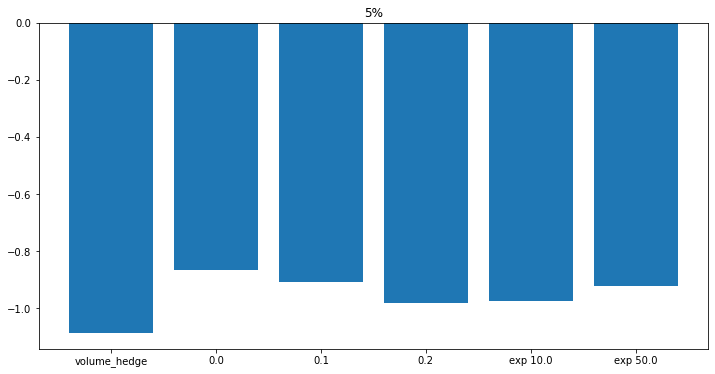

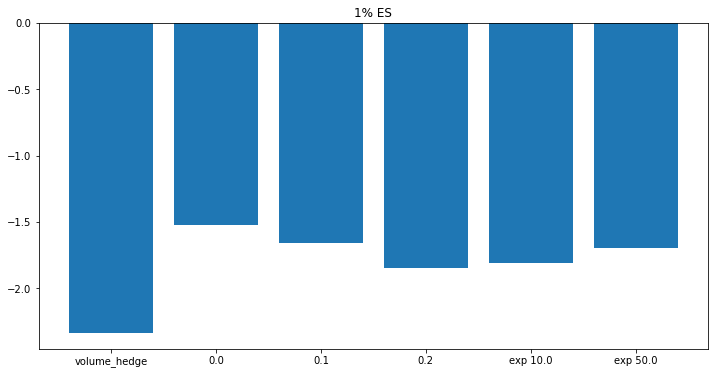

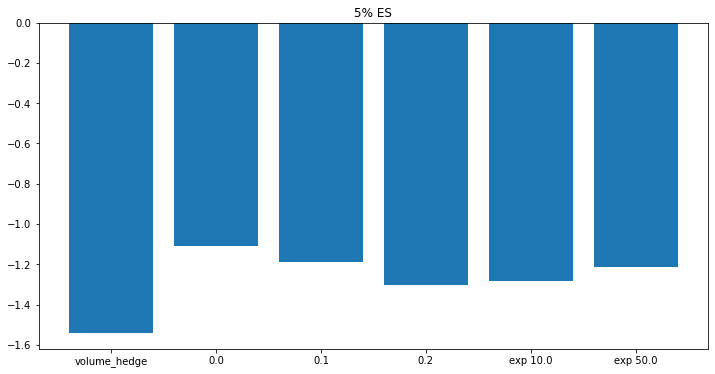

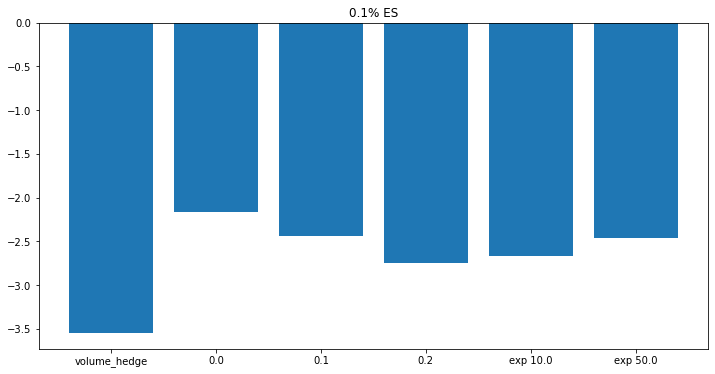

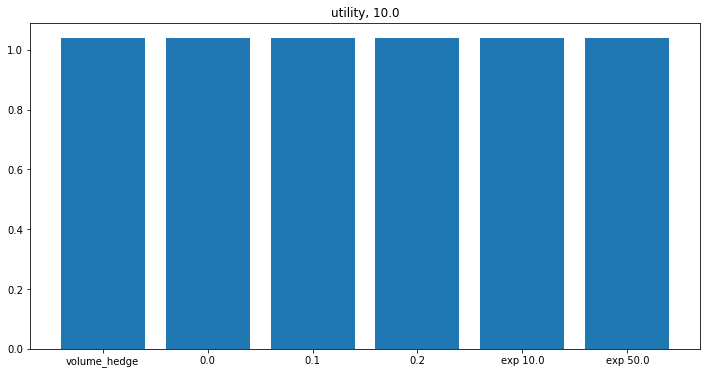

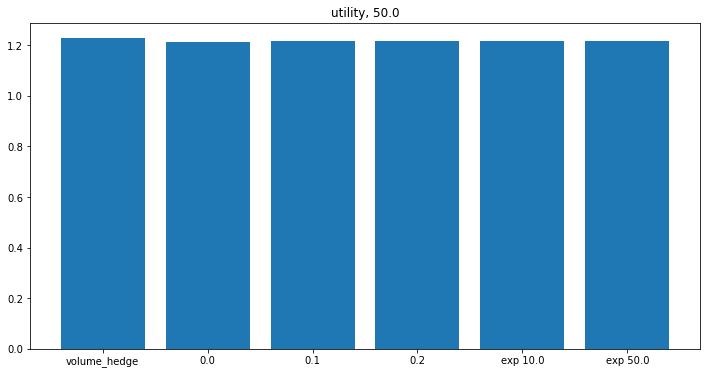

In [130]:
for k in pnl_stat.columns:
    if k == 'name':
        continue
    names = list(pnl_stat['name'])
    values = list(pnl_stat[k])
    plt.figure(figsize=(12,6))
    plt.title(k)
    plt.bar(range(len(names)), values, tick_label=names);

### Distribution

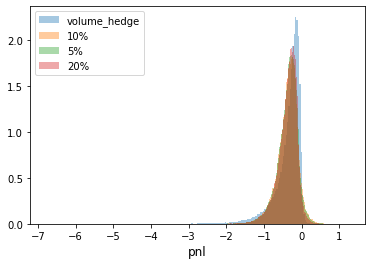

In [87]:
#plt.figure(figsize=(15,8))
alpha = 0.4#1.0/len(pnl)
#plt.hist(pnl_volume_hedge,bins=100, label='volume hedge', alpha=alpha, density=True)

order = []
for k,v in pnl.items():
    order.append((np.var(v),k))
    
order.sort(reverse=True)
order = [k[1] for k in order]
ignored = ['no_hedge', 
           'static_volume_hedge',
           #'volume_hedge',
           #'0.2',
           '0.5',
           #'0.8',
           #'volume_hedge',
           #'0.1',
           #'0.2',
           'utility, 10',
           'utility, 50',
           #'0.0'
          ]
for k in order:
    if k in ignored:
        continue
    pnl_= pnl[k]#pnl[k] #np.clip(pnl[k], -0.005,0.005)
    plt.hist(100*pnl_,bins=200, label=k, alpha=alpha, density=True)#,  histtype='step')
plt.legend()
#plt.xlim(-3,2.0)
plt.xlabel('pnl', fontsize=12);
plt.savefig(result_dir+'pnl_distributions.png', dpi=400)

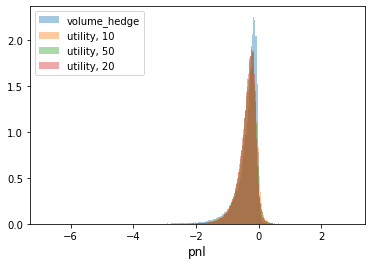

In [112]:
#plt.figure(figsize=(15,8))
alpha = 0.4#1.0/len(pnl)
#plt.hist(pnl_volume_hedge,bins=100, label='volume hedge', alpha=alpha, density=True)

order = []
for k,v in pnl.items():
    order.append((np.var(v),k))
    
order.sort(reverse=True)
order = [k[1] for k in order]
ignored = ['no_hedge', 
           'static_volume_hedge',
           #'volume_hedge',
           #'0.2',
           '0.5',
           #'0.8',
           #'volume_hedge',
           #'0.1',
           #'0.2',
           'utility, 20'
           #'utility, 10',
           'utility, 50',
           #'0.0'
          ]
for k in order:
    if k in ignored:
        continue
    pnl_= pnl[k]#pnl[k] #np.clip(pnl[k], -0.005,0.005)
    plt.hist(100*pnl_,bins=200, label=k, alpha=alpha, density=True)#,  histtype='step')
plt.legend()
#plt.xlim(-3,2.0)
plt.xlabel('pnl', fontsize=12);
plt.savefig(result_dir+'pnl_distributions.png', dpi=400)

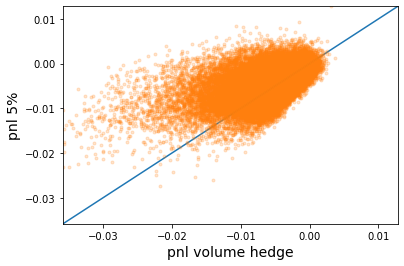

In [60]:
key = '5%' #'0.0'
pnl_min = np.min(pnl[key])
pnl_max = np.max(pnl[key])

plt.plot([pnl_min,pnl_max], [pnl_min,pnl_max], '-')
plt.plot(pnl['volume_hedge'], pnl[key],'.', alpha=0.2)

plt.xlim(pnl_min, pnl_max)
plt.ylim(pnl_min, pnl_max)
plt.xlabel('pnl volume hedge', fontsize=14)
plt.ylabel('pnl '+key, fontsize=14);
plt.savefig(result_dir+'pnl_comparison_scatter.png', dpi=400)

### Dependencies

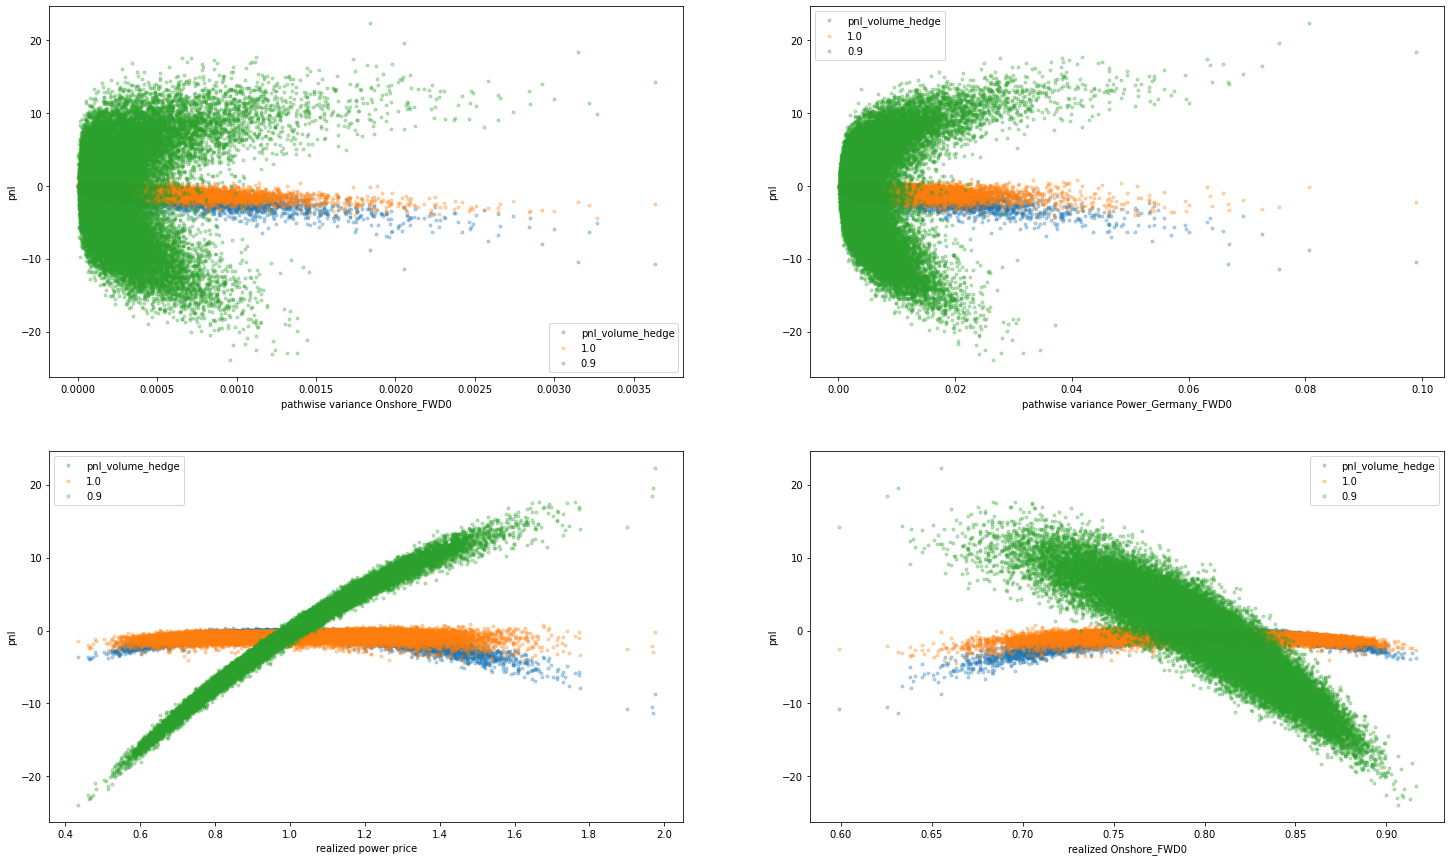

In [80]:
plt.figure(figsize=(25,15))

power_price = paths.get('Power_Germany_FWD0', None)
volume = paths.get(spec.location+'_FWD0')
volume_var = volume.var(axis=0)
plt.subplot(2,2,1)
#plt.hist(volume_var, bins=100, density=True);
for k,v in pnl.items():
    if k == '0.5':
        continue
    plt.plot(volume_var, 100.0*v, '.', alpha=0.3, label=k)
plt.legend()
plt.ylabel('pnl')
plt.xlabel('pathwise variance Onshore_FWD0')

plt.subplot(2,2,2)
power_var = power_price.var(axis=0)
#plt.hist(volume_var, bins=100, density=True);
for k,v in pnl.items():
    if k == '0.5':
        continue
    plt.plot(power_var, 100.0*v, '.', alpha=0.3, label=k)
plt.legend()
plt.ylabel('pnl')
plt.xlabel('pathwise variance Power_Germany_FWD0');

plt.subplot(2,2,3)
for k,v in pnl.items():
    if k == '0.5':
        continue
    plt.plot(power_price[-1,:], 100.0*v, '.', alpha=0.3, label=k)
plt.legend()
plt.ylabel('pnl')
plt.xlabel('realized power price');

plt.subplot(2,2,4)
for k,v in pnl.items():
    if k == '0.5':
        continue
    plt.plot(volume[-1,:], 100.0*v, '.', alpha=0.3, label=k)
plt.legend()
plt.ylabel('pnl')
plt.xlabel('realized Onshore_FWD0');
plt.savefig(result_dir+'pnl_vs_paths.png', dpi=400)

In [15]:
hedge_models.items()

dict_items([('7525471af6019d720fe596c36a689a8bcbaf6c3b', <rivapy.pricing.deep_hedging.DeepHedgeModel object at 0x7f3992178d00>)])

## Delta Plots

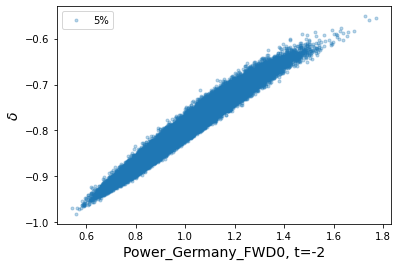

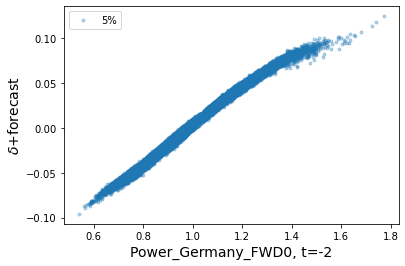

In [62]:
t = -2
n_x = 1
n_y = 3

#plt.figure(figsize=(24,8))
volume_hedge=-1.0*paths[ref_keys[0]]['Onshore_FWD0'][t,:]
for k in ['5%',
          #'0.1',
         # '0.0'
         ]:
    key = labels_T[k]
    hedge_model = hedge_models[key]

    #plt.figure(figsize=(24,8))
    #if labels[key] in ['1.0','0.5']:
    #    continue
    delta = hedge_model.compute_delta(paths[key], t).reshape((-1,))
    v = paths[key]['Power_Germany_FWD0']
    plt.plot(v[t,:], delta,'.', label=labels[key], alpha=0.3)#+paths[key]['Onshore_FWD0'][t,:]
    plt.xlabel('Power_Germany_FWD0'+', t='+str(t), fontsize=14)
    plt.ylabel('$\delta$', fontsize=14)
plt.legend()
plt.savefig(result_dir+'delta_vs_power'+str(t)+'.png', dpi=400)
plt.figure()
for k in ['5%',#'0.1',
         # '0.0'
         ]:
    key = labels_T[k]
    hedge_model = hedge_models[key]

    #plt.figure(figsize=(24,8))
    #if labels[key] in ['1.0','0.5']:
    #    continue
    delta = hedge_model.compute_delta(paths[key], t).reshape((-1,))
    v = paths[key]['Power_Germany_FWD0']
    plt.plot(v[t,:], delta+paths[key]['Onshore_FWD0'][t,:],'.', label=labels[key], alpha=0.3)#
    plt.xlabel('Power_Germany_FWD0'+', t='+str(t), fontsize=14)
    plt.ylabel('$\delta$+forecast', fontsize=14)
plt.legend()
plt.savefig(result_dir+'delta_diff_vs_power'+str(t)+'.png', dpi=400);


In [17]:
if False:
    t = -2
    n_x = 1
    n_y = 3
    ignored = ['no_hedge', 
               'static_volume_hedge',
               '0.5',
               #'volume_hedge',
               '0.1',
               '0.2',
               'exp 10.0',
               'exp 50.0',
               #'0.0'
              ]
    #plt.figure(figsize=(24,8))
    volume_hedge=-1.0*paths[ref_keys[0]]['Onshore_FWD0'][t,:]
    plot_volume_hedge = True
    for key, hedge_model in hedge_models.items():
        if labels[key] in ignored:
            continue
        #plt.figure(figsize=(24,8))
        #if labels[key] in ['1.0','0.5']:
        #    continue
        delta = hedge_model.compute_delta(paths[key], t).reshape((-1,))
        i=1

        for k,v in paths[key].items():
            plt.figure()
            #plt.subplot(n_x, n_y, i)
            plt.plot(v[t,:], delta+paths[key]['Onshore_FWD0'][t,:],'.', label=labels[key], alpha=0.3)
            #if plot_volume_hedge and True:
            #    plt.plot(v[t,:], volume_hedge, '.', label='volume hedge', alpha=0.3)
            if k == 'Onshore_FWD0':
                plt.plot([0.6,0.95],[-0.6,-0.95])
            plt.xlabel(k+', t='+str(t))
            plt.ylabel('delta')
            plt.legend()
            i+= 1
        plot_volume_hedge = False

    plt.legend()
    #plt.savefig(result_dir+'delta_'+str(t)+'.png', dpi=400)
    if False:
        for k,v in paths.items():
            plt.subplot(n_x, n_y, i)
            plt.plot(v[t,:], v[-1,:],'.')
            plt.xlabel(k+', t='+str(t))
            plt.ylabel(k+', final')
            i+= 1

In [63]:
delta = {'volume hedge': -paths[ref_keys[0]].get('Onshore_FWD0')}
for key, hedge_model in hedge_models.items():
    d = hedge_model.compute_delta(paths[key])
    delta[labels[key]] = d.reshape((d.shape[0],-1))

In [64]:
key = '5%'
paths[ref_keys[0]].get('Power_Germany_FWD0')
pnl_diff = pnl[key] - pnl['volume_hedge']
plt.plot(power[-1,:], pnl_diff, '.', alpha=0.1)
plt.xlabel('final power price')
plt.ylabel('pnl difference')
plt.axhline(0.0, color='r')
plt.savefig(result_dir+'power_price_vs_pnl_dif'+str(t)+'.png', dpi=400);
plt.figure()
wind = paths[ref_keys[0]].get('Onshore_FWD0')
pnl_diff = pnl[key] - pnl['volume_hedge']
plt.plot(wind[-1,:], pnl_diff, '.', alpha=0.1)
plt.xlabel('final wind')
plt.ylabel('pnl difference')
plt.axhline(0.0, color='r')
plt.savefig(result_dir+'wind_vs_pnl_dif'+str(t)+'.png', dpi=400);

NameError: name 'power' is not defined

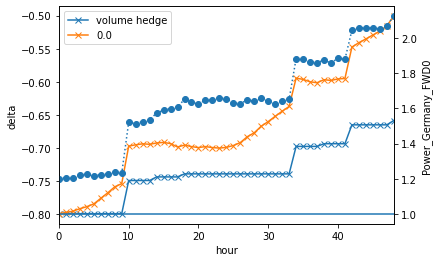

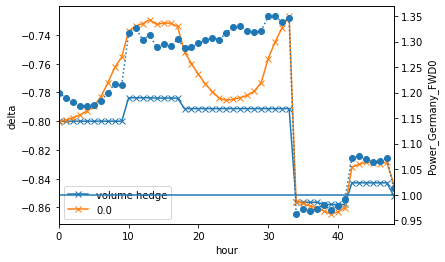

In [83]:
pnl_diff = pnl['0.0'] - pnl['volume_hedge']
n_paths = [(np.argmax(pnl_diff), 'max_pnl_diff'), (np.argmin(pnl_diff), 'min_pnl_diff')]
ignore = ['0.2', '0.5']
for n_path, n_path_name in n_paths:
    plt.figure()
    #plt.figure(figsize=(10,8))
    for k,v in delta.items():
        if k in ignore:
            continue
        plt.plot(v[:,n_path], '-x', label=k)
    plt.legend()  
    plt.ylabel('delta')
    plt.xlabel('hour'); 
    ax2 = plt.twinx() 
    power = paths[ref_keys[0]].get('Power_Germany_FWD0')
    ax2.plot(power[:,n_path],':o')
    ax2.set_ylabel('Power_Germany_FWD0')
    ax2.axhline(1.0)
    plt.xlim(0,48);
    plt.savefig(result_dir+'delta_path_'+n_path_name+'.png', dpi=400);

In [73]:
result_dir

'results/varying_regularization_ITM/'